---
title: "Analysing MQM error profiles and metric correlations in MT systems"
subtitle: "Multilingual NLP -- Lab 3"
author: "Philippos Triantafyllou"
date-modified: last-modified
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../_pandoc/doc-class.tex"
            - "../_pandoc/toc.tex"
            - "../_pandoc/before-title.tex"
toc: true
toc-depth: 3
number-depth: 1
number-sections: true
highlight-style: github
fig-cap-location: top
execute:
  echo: true
  output: true
embed-resources: true
---

## Data loading

In [1]:
import pandas as pd

pd.set_option("display.max_colwidth", 20)

In [2]:
# Load the TSV file
df = pd.read_csv("data/mqm_2022_ende.tsv", sep="\t")

# # Select required columns
cols = ["system_id", "doc_segment_id", "category", "severity", "source", "candidate", "reference"]
df = df[cols]
df = df.rename(columns={'system_id': 'system', 'candidate': 'target', 'doc_segment_id': 'segment'})

display(df)
print(df.shape)

,system,segment,category,severity,source,target,reference
0,JDExploreAcademy,1,style/awkward,minor,Avalanche at Was...,Lawine in Skigeb...,Lawine in Ski-Re...
1,JDExploreAcademy,1,style/awkward,minor,Avalanche at Was...,Lawine in Skigeb...,Lawine in Ski-Re...
2,JDExploreAcademy,1,no-error,no-error,Avalanche at Was...,Lawine in Skigeb...,Lawine in Ski-Re...
3,JDExploreAcademy,1,accuracy/mistran...,minor,Avalanche at Was...,Lawine in Skigeb...,Lawine in Ski-Re...
4,Lan-Bridge,1,style/awkward,minor,Avalanche at Was...,Lawine im Skigeb...,Lawine in Ski-Re...
...,...,...,...,...,...,...,...
78554,comet_bestmbr,10,no-error,no-error,I shall never fo...,Ich werde diesen...,Ich werde nie di...
78555,refB,10,fluency/punctuation,minor,I shall never fo...,<v>Ich</v> werde...,Ich werde nie di...
78556,refB,10,fluency/punctuation,minor,I shall never fo...,Ich werde diesen...,Ich werde nie di...
78557,refB,10,no-error,no-error,I shall never fo...,Ich werde diesen...,Ich werde nie di...


(78559, 7)


Doing some cleaning.

In [3]:
# Drop rows with missing annotations in key fields
df = df.dropna(subset=["system", "segment", "category", "severity", "source", "target", "reference"]).reset_index(drop=True)
display(df.shape)

(78559, 7)

In [4]:
# View the unique category and severity labels
print("Unique Categories:", df["category"].unique())
print("Unique Severities:", df["severity"].unique())

Unique Categories: ['style/awkward' 'no-error' 'accuracy/mistranslation'
 'accuracy/untranslated' 'fluency/grammar' 'accuracy/addition'
 'accuracy/omission' 'terminology/inappropriate' 'locale_convention/time'
 'fluency/register' 'terminology/inconsistent' 'fluency/spelling'
 'fluency/punctuation' 'fluency/display' 'fluency/inconsistency'
 'locale_convention/currency' 'source_error' 'other' 'non_translation'
 'locale_convention/date' 'locale_convention/name']
Unique Severities: ['minor' 'no-error' 'major']


In [5]:
# Build a major category variable
df["major_category"] = df["category"].apply(lambda x: x.split("/")[0].split(".")[0].strip() if pd.notnull(x) else x)
df["major_category"].unique()

array(['style', 'no-error', 'accuracy', 'fluency', 'terminology',
       'locale_convention', 'source_error', 'other', 'non_translation'],
      dtype=object)

The data is now ready to work with.

## Building and visualizing error profiles

First we build for each system its error profile as a vector of error counts per major category.

In [6]:
df_err = df[df["major_category"] != "no-error"].copy()

In [7]:
# Count errors per system and category
error_counts = (df_err.groupby(["system", "major_category"]).size().unstack(fill_value=0))

In [8]:
display(error_counts)

major_category,accuracy,fluency,locale_convention,non_translation,other,source_error,style,terminology
system,,,,,,,,
JDExploreAcademy,957,874,4,0,1,14,680,114
Lan-Bridge,1233,1362,5,0,4,19,678,90
M2M100_1.2B-B4,2681,2054,2,3,9,17,920,143
Online-A,1151,1468,4,1,4,27,742,87
Online-B,940,967,5,0,8,24,555,107
Online-G,1177,1516,16,1,20,18,724,97
Online-W,673,1082,9,0,2,15,500,73
Online-Y,1256,1312,7,0,14,19,652,103
OpenNMT,1657,921,4,0,5,18,656,100


In [9]:
# count target-side tokens
df_err["target_tokens"] = df_err["target"].str.split().str.len()

tokens_per_system = (df_err.groupby("system")["target_tokens"].sum())

error_freq_per_token = error_counts.div(tokens_per_system, axis=0)

In [10]:
display(error_freq_per_token)

major_category,accuracy,fluency,locale_convention,non_translation,other,source_error,style,terminology
system,,,,,,,,
JDExploreAcademy,0.017037,0.015560,0.000071,0.000000,0.000018,0.000249,0.012106,0.002030
Lan-Bridge,0.017461,0.019287,0.000071,0.000000,0.000057,0.000269,0.009601,0.001274
M2M100_1.2B-B4,0.022451,0.017200,0.000017,0.000025,0.000075,0.000142,0.007704,0.001197
Online-A,0.015857,0.020225,0.000055,0.000014,0.000055,0.000372,0.010223,0.001199
Online-B,0.018068,0.018587,0.000096,0.000000,0.000154,0.000461,0.010668,0.002057
Online-G,0.015959,0.020555,0.000217,0.000014,0.000271,0.000244,0.009817,0.001315
Online-W,0.014108,0.022682,0.000189,0.000000,0.000042,0.000314,0.010482,0.001530
Online-Y,0.019116,0.019969,0.000107,0.000000,0.000213,0.000289,0.009923,0.001568
OpenNMT,0.023920,0.013295,0.000058,0.000000,0.000072,0.000260,0.009470,0.001444


Then we visualize using a radar plot.

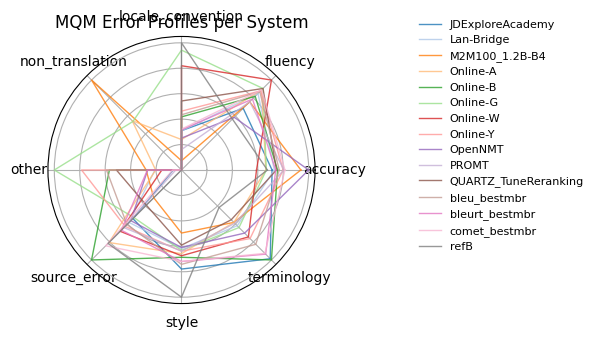

In [11]:
#| echo: false

import numpy as np
import matplotlib.pyplot as plt

plot_df = error_freq_per_token / error_freq_per_token.max()

categories = plot_df.columns.tolist()
n_cat = len(categories)

angles = np.linspace(0, 2 * np.pi, n_cat, endpoint=False)
angles = np.r_[angles, angles[0]]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# pick a colormap with many distinct colors
cmap = plt.colormaps["tab20"]

for i, (system, row) in enumerate(plot_df.iterrows()):
    values = row.to_numpy(dtype=float)
    values = np.r_[values, values[0]]
    ax.plot(
        angles,
        values,
        color=cmap(i),
        linewidth=1,
        alpha=0.8,
        label=system,
    )

ax.set_thetagrids(angles[:-1] * 180 / np.pi, categories)
ax.set_yticklabels([])
ax.set_title("MQM Error Profiles per System")

ax.legend(
    bbox_to_anchor=(1.35, 1.1),
    loc="upper left",
    fontsize=8,
    frameon=False,
)

plt.tight_layout()
plt.show()

## Clustering systems by error profiles

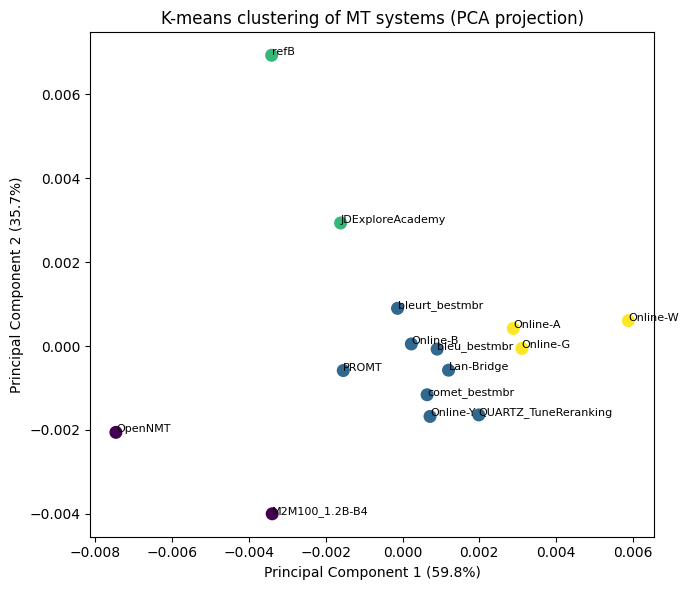

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

error_frequency_dataframe = error_freq_per_token
system_names = error_frequency_dataframe.index
feature_matrix = error_frequency_dataframe.values

number_of_clusters = 4
kmeans_model = KMeans(
    n_clusters=number_of_clusters,
    n_init=10,
    random_state=0,
)
cluster_labels = kmeans_model.fit_predict(feature_matrix)

pca_model = PCA(n_components=2)
pca_coordinates = pca_model.fit_transform(feature_matrix)

explained_variance = pca_model.explained_variance_ratio_

plt.figure(figsize=(7, 6))
plt.scatter(
    pca_coordinates[:, 0],
    pca_coordinates[:, 1],
    c=cluster_labels,
    s=70,
)

for i, system_name in enumerate(system_names):
    plt.text(
        pca_coordinates[i, 0],
        pca_coordinates[i, 1],
        system_name,
        fontsize=8,
    )

plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.1f}%)")
plt.title("K-means clustering of MT systems (PCA projection)")
plt.tight_layout()
plt.show()

## MQM and Automatic Metrics

In [ ]:
#| include: false

!pip -q install unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 22.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 37.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sacrebleu
import torch

from scipy.stats import pearsonr, spearmanr
from comet import load_from_checkpoint
from comet.models import download_model 

In [24]:
import pandas as pd

# Define the required columns for metric computation
required_columns = ["system", "segment", "source", "target", "reference"]

# Keep only the columns needed to compute segment/system metrics
metrics_input_dataframe = df[required_columns].copy()

# Drop rows missing any of the text fields needed for metrics
metrics_input_dataframe = metrics_input_dataframe.dropna(subset=["source", "target", "reference"])

# Build the segment-level table (one row per system–segment)
segment_level_metrics_table = metrics_input_dataframe.drop_duplicates(subset=["system", "segment"])

# Build the system-level table skeleton (one row per system)
system_level_metrics_table = (
    segment_level_metrics_table.groupby("system", as_index=False)
    .agg(num_segments=("segment", "nunique"))
)

Computing weighted MQM scores following Freitag et al.

In [25]:
# Severity weighting scheme
severity_weights = {
    "minor": 1,
    "major": 5,
}

# Map severities to weights
# "no-error" -> NaN (ignored automatically)
df["mqm_weight"] = df["severity"].map(severity_weights)

Segment level MQM scores.

In [26]:
mqm_segment_scores = df.groupby(["system", "segment"])["mqm_weight"].sum(min_count=1).reset_index(name="mqm_score")
segment_level_metrics_table = segment_level_metrics_table.merge(mqm_segment_scores, on=["system", "segment"], how="left")

System level MQM scores normalized by total tokens per system.

In [27]:
df["target_tokens"] = df["target"].str.split().str.len()
tokens_per_system = (df.groupby("system")["target_tokens"].sum())
mqm_system_scores = (df.groupby("system")["mqm_weight"].sum(min_count=1))
mqm_system_scores_norm = mqm_system_scores / tokens_per_system

system_level_metrics_table = system_level_metrics_table.merge(
    mqm_system_scores_norm.reset_index(name="mqm_score_per_token"),
    on="system",
    how="left",
)

Computing BLEU and chrF scores at the segment level.

In [28]:
bleu_scores = []
chrf_scores = []

for _, row in segment_level_metrics_table.iterrows():
    bleu = sacrebleu.sentence_bleu(row["target"], [row["reference"]]).score
    chrf = sacrebleu.sentence_chrf(row["target"], [row["reference"]]).score
    bleu_scores.append(bleu)
    chrf_scores.append(chrf)

# Add segment-level BLEU and chrF to the segment-level metrics table
segment_level_metrics_table["BLEU"] = bleu_scores
segment_level_metrics_table["chrF"] = chrf_scores

System level BLEU and chrF scores.

In [29]:
# Compute corpus-level BLEU and chrF for each system using the segment-level metrics table
system_metric_results = []

for system_name in segment_level_metrics_table["system"].unique():
    system_segments = segment_level_metrics_table[segment_level_metrics_table["system"] == system_name]

    # Collect hypotheses and references for the full system output
    hypotheses = system_segments["target"].astype(str).tolist()
    references = [system_segments["reference"].astype(str).tolist()]

    # Compute corpus-level BLEU (system-level)
    bleu_score = sacrebleu.corpus_bleu(hypotheses, references).score

    # Compute corpus-level chrF (system-level)
    chrf_score = sacrebleu.corpus_chrf(hypotheses, references).score

    system_metric_results.append({
        "system": system_name,
        "BLEU": bleu_score,
        "chrF": chrf_score,
    })

# Put BLEU/chrF results into a separate table (one row per system)
system_level_bleu_chrf_table = pd.DataFrame(system_metric_results)

# Merge BLEU/chrF into the existing system-level metrics table (do NOT overwrite it)
system_level_metrics_table = system_level_metrics_table.merge(system_level_bleu_chrf_table, on="system", how="left")

COMET score.

In [ ]:
#| output: false
#| warning: false

# Load the COMET-DA model (reference-based, suitable for MQM correlation)
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

# Prepare COMET inputs from the segment-level metrics table (one row per system–segment)
comet_inputs = [
    {
        "src": row["source"],
        "mt": row["target"],
        "ref": row["reference"],
    }
    for _, row in segment_level_metrics_table.iterrows()
]

# Run COMET to obtain segment-level scores
comet_output = comet_model.predict(
    comet_inputs,
    batch_size=32,
    gpus=1 if torch.cuda.is_available() else 0,
    num_workers=1,
)

# Add segment-level COMET scores to the segment-level metrics table
segment_level_metrics_table["COMET"] = comet_output["scores"]

# Aggregate system-level COMET as the mean of segment-level scores
comet_system_scores = segment_level_metrics_table.groupby("system")["COMET"].mean()

# Merge system-level COMET into the existing system-level metrics table
system_level_metrics_table = system_level_metrics_table.merge(
    comet_system_scores.rename("COMET"),
    on="system",
    how="left",
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

LICENSE: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() wil

In [ ]:
#| include: false
#| eval: false

segment_level_metrics_table.to_csv("segment_level_metrics.csv", index=False)
system_level_metrics_table.to_csv("system_level_metrics.csv", index=False)

In [72]:
segment_level_metrics_table = pd.read_csv("data/segment_level_metrics.csv")
system_level_metrics_table = pd.read_csv("data/system_level_metrics.csv")

In [73]:
display(segment_level_metrics_table)
display(system_level_metrics_table)

,system,segment,source,target,reference,mqm_score,BLEU,chrF,COMET,char_length,num_tokens,num_types,herdan_c,cluster_id,embedding_cluster
0,JDExploreAcademy,1,Avalanche at Was...,Lawine in Skigeb...,Lawine in Ski-Re...,579.0,12.512237,67.030184,0.831794,57,10,10,1.0,0,1
1,Lan-Bridge,1,Avalanche at Was...,Lawine im Skigeb...,Lawine in Ski-Re...,648.0,5.328642,46.011332,0.613065,57,10,10,1.0,0,1
2,M2M100_1.2B-B4,1,Avalanche at Was...,<v>Avalanche</v>...,Lawine in Ski-Re...,1533.0,5.108099,29.772569,0.682823,57,10,10,1.0,0,1
3,Online-A,1,Avalanche at Was...,Lawine im Skigeb...,Lawine in Ski-Re...,698.0,10.825978,35.216326,0.601003,57,10,10,1.0,0,1
4,Online-B,1,Avalanche at Was...,Lawine im Skigeb...,Lawine in Ski-Re...,544.0,8.961672,46.790274,0.740459,57,10,10,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,QUARTZ_TuneReran...,10,"""Skiers can trav...","""Im Staatswald k...",„Skifahrer könne...,567.0,2.707658,30.971447,0.754541,69,12,12,1.0,4,0
146,bleu_bestmbr,10,"""Skiers can trav...",„Skifahrer könne...,„Skifahrer könne...,350.0,9.507244,38.375831,0.793060,69,12,12,1.0,4,0
147,bleurt_bestmbr,10,"""Skiers can trav...",„Skifahrer könne...,„Skifahrer könne...,490.0,8.913766,37.910226,0.897374,69,12,12,1.0,4,0
148,comet_bestmbr,10,"""Skiers can trav...",„Skifahrer könne...,„Skifahrer könne...,469.0,8.913766,38.409848,0.908579,69,12,12,1.0,4,0


,system,num_segments,mqm_score_per_token,BLEU,chrF,COMET
0,JDExploreAcademy,10,0.054599,32.666188,61.775083,0.822923
1,Lan-Bridge,10,0.064303,24.708933,59.038817,0.761160
2,M2M100_1.2B-B4,10,0.091230,21.711807,55.987241,0.721010
3,Online-A,10,0.060145,27.270501,59.721487,0.786887
4,Online-B,10,0.054561,25.004807,59.665942,0.770541
5,Online-G,10,0.062263,26.326593,60.875855,0.758391
6,Online-W,10,0.044980,34.177264,62.279745,0.845575
7,Online-Y,10,0.062435,25.471897,59.843116,0.740286
8,OpenNMT,10,0.075304,27.706626,60.139061,0.754235
9,PROMT,10,0.070187,25.850586,61.062388,0.763773


System level correlations.

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Collect system-level correlation results in a structured table
system_correlation_results = []

for metric_name in ["BLEU", "chrF", "COMET"]:
    pearson_r, _ = pearsonr(
        system_level_metrics_table["mqm_score_per_token"],
        system_level_metrics_table[metric_name],
    )
    spearman_r, _ = spearmanr(
        system_level_metrics_table["mqm_score_per_token"],
        system_level_metrics_table[metric_name],
    )

    system_correlation_results.append({
        "metric": metric_name,
        "pearson_r": pearson_r,
        "spearman_r": spearman_r,
    })

# Convert to DataFrame
system_correlation_table = pd.DataFrame(system_correlation_results)

system_correlation_table

,metric,pearson_r,spearman_r
0,BLEU,-0.474604,-0.417857
1,chrF,-0.420903,-0.392857
2,COMET,-0.778326,-0.707143


Segment level correlations.

In [68]:
# Collect segment-level correlation results in a structured table
segment_correlation_results = []

for metric_name in ["BLEU", "chrF", "COMET"]:
    pearson_r, _ = pearsonr(
        segment_level_metrics_table["mqm_score"],
        segment_level_metrics_table[metric_name],
    )
    spearman_r, _ = spearmanr(
        segment_level_metrics_table["mqm_score"],
        segment_level_metrics_table[metric_name],
    )

    segment_correlation_results.append({
        "metric": metric_name,
        "pearson_r": pearson_r,
        "spearman_r": spearman_r,
    })

# Convert to DataFrame
segment_correlation_table = pd.DataFrame(segment_correlation_results)

segment_correlation_table

,metric,pearson_r,spearman_r
0,BLEU,-0.030795,-0.073729
1,chrF,-0.024369,0.032225
2,COMET,-0.088716,-0.071358


Plotting segment level MQM vs automatic metrics.

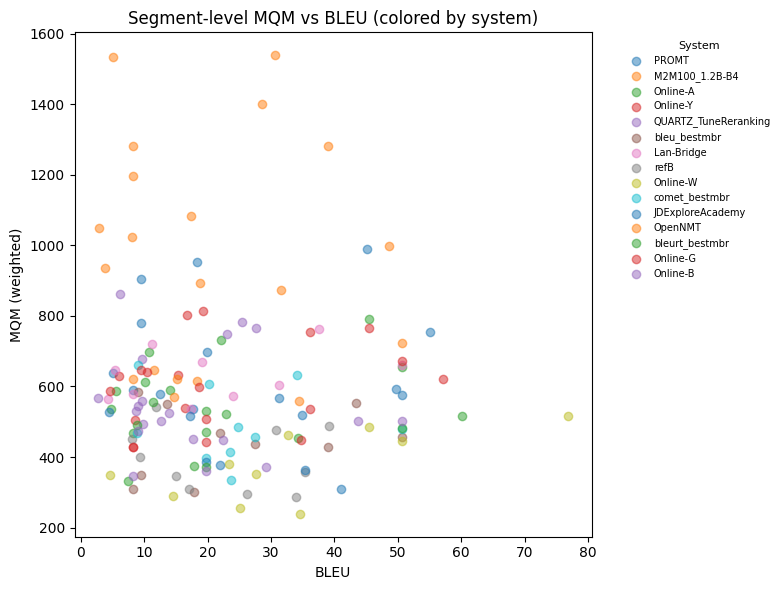

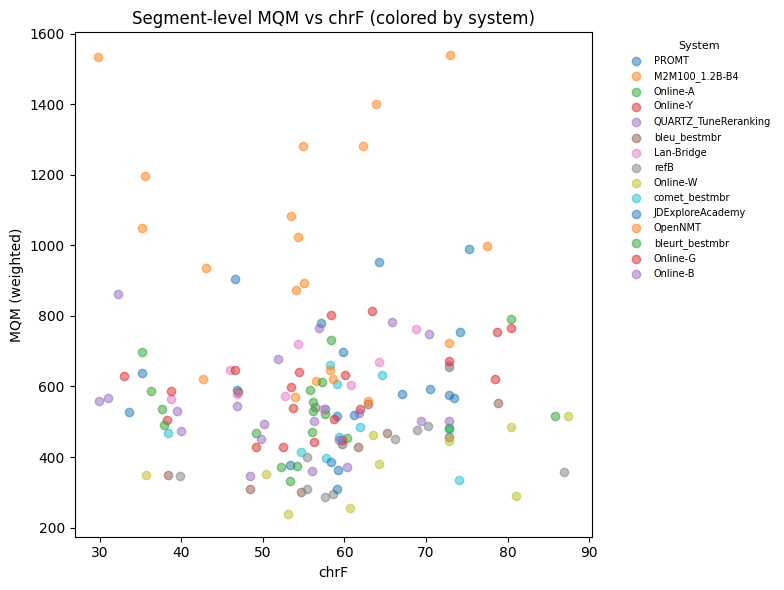

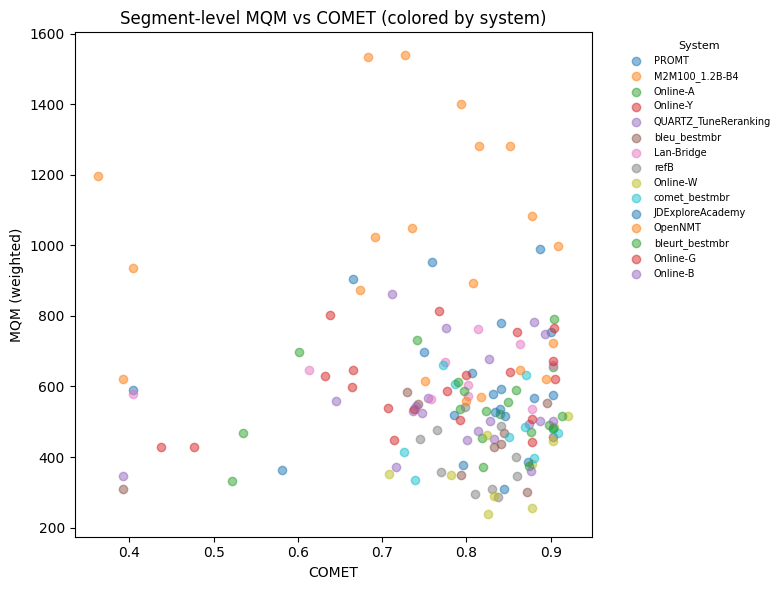

In [47]:
import matplotlib.pyplot as plt

# Define how many points to plot (avoid overplotting)
sample_size = min(3000, len(segment_level_metrics_table))
sampled_segments = segment_level_metrics_table.sample(n=sample_size, random_state=0)

# Get unique systems
systems = sampled_segments["system"].unique()

# Plot segment-level MQM vs each automatic metric, colored by system with legend
for metric_name in ["BLEU", "chrF", "COMET"]:
    plt.figure(figsize=(8, 6))

    for system_name in systems:
        system_data = sampled_segments[sampled_segments["system"] == system_name]

        plt.scatter(
            system_data[metric_name],
            system_data["mqm_score"],
            alpha=0.5,
            label=system_name,
        )

    plt.xlabel(metric_name)
    plt.ylabel("MQM (weighted)")
    plt.title(f"Segment-level MQM vs {metric_name} (colored by system)")

    plt.legend(
        title="System",
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

And at system level.

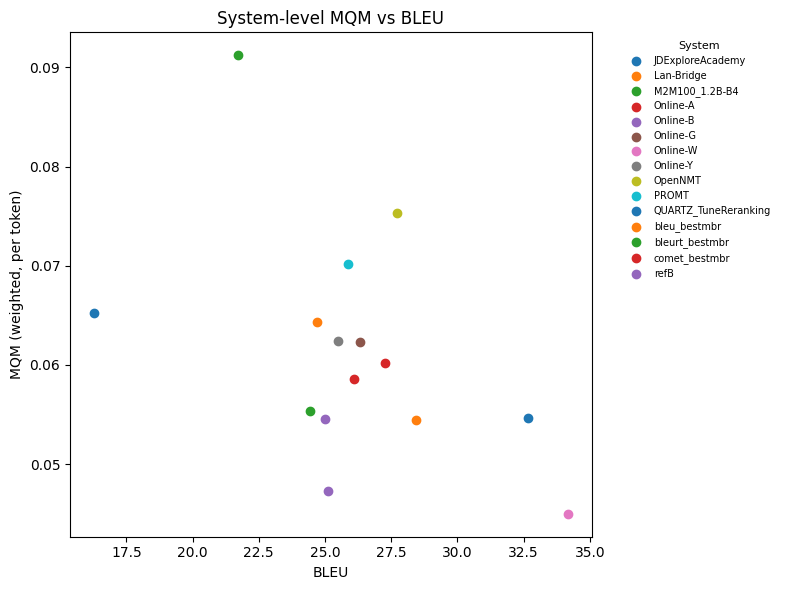

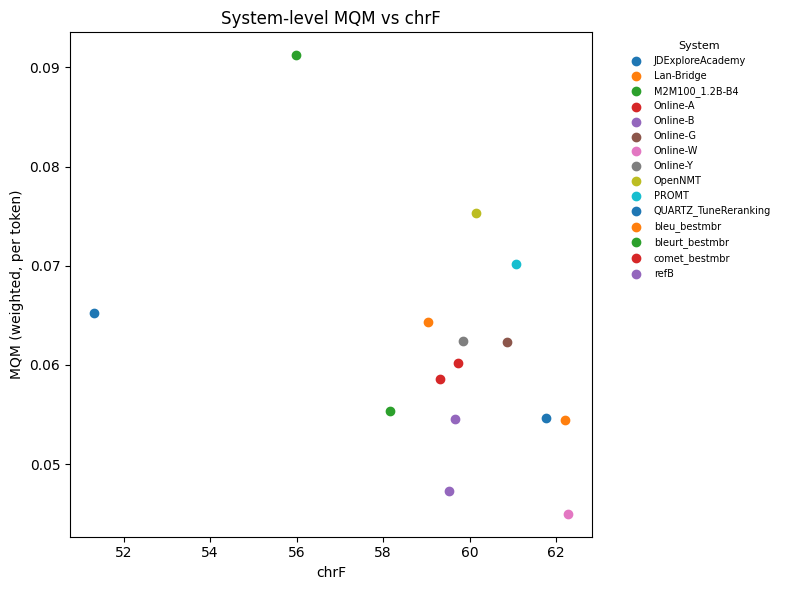

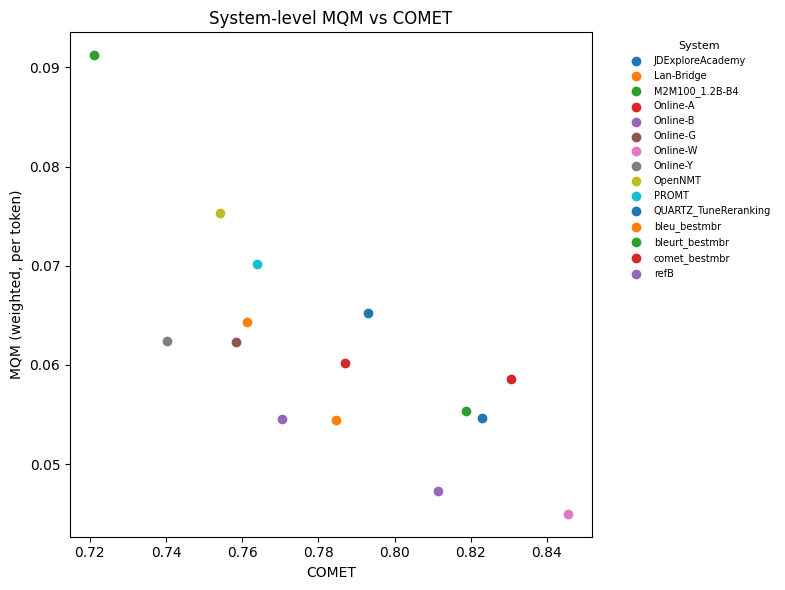

In [46]:
import matplotlib.pyplot as plt

# Get unique systems
systems = system_level_metrics_table["system"].unique()

# Plot system-level MQM vs each automatic metric, colored by system with legend
for metric_name in ["BLEU", "chrF", "COMET"]:
    plt.figure(figsize=(8, 6))

    for system_name in systems:
        system_data = system_level_metrics_table[system_level_metrics_table["system"] == system_name]

        plt.scatter(
            system_data[metric_name],
            system_data["mqm_score_per_token"],
            label=system_name,
        )

    plt.xlabel(metric_name)
    plt.ylabel("MQM (weighted, per token)")
    plt.title(f"System-level MQM vs {metric_name}")

    plt.legend(
        title="System",
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

## Linguistic factors and correlation

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

Computing surface features:

- Character length of the source sentence
- Hedran's C.

In [49]:
# Character length of the source sentence
segment_level_metrics_table["char_length"] = segment_level_metrics_table["source"].astype(str).str.len()

# Tokenize source sentences (simple whitespace tokenization)
source_tokens = segment_level_metrics_table["source"].astype(str).str.split()

# Number of tokens per segment
segment_level_metrics_table["num_tokens"] = source_tokens.str.len()

# Number of unique tokens per segment
segment_level_metrics_table["num_types"] = source_tokens.apply(lambda toks: len(set(toks)) if toks else 0)

# Herdan’s C: log(V) / log(N); undefined for N <= 1 → set to NaN
segment_level_metrics_table["herdan_c"] = np.where(
    segment_level_metrics_table["num_tokens"] > 1,
    np.log(segment_level_metrics_table["num_types"]) / np.log(segment_level_metrics_table["num_tokens"]),
    np.nan,
)

TF-IDF clustering of source sentences.

In [50]:
# Build TF–IDF vectors from source sentences
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=5000,
)

tfidf_matrix = tfidf_vectorizer.fit_transform(
    segment_level_metrics_table["source"].astype(str)
)

# Number of clusters (keep small and interpretable)
num_clusters = 5

kmeans_model = KMeans(
    n_clusters=num_clusters,
    n_init=10,
    random_state=0,
)

cluster_ids = kmeans_model.fit_predict(tfidf_matrix)

# Append cluster labels to the segment-level metrics table
segment_level_metrics_table["cluster_id"] = cluster_ids

Recomputing correlations per cluster.

In [69]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Collect TF–IDF cluster-level correlation results in a structured table
cluster_correlation_results = []

for cluster_id in sorted(segment_level_metrics_table["cluster_id"].unique()):
    cluster_data = segment_level_metrics_table[
        segment_level_metrics_table["cluster_id"] == cluster_id
    ]

    for metric_name in ["BLEU", "chrF", "COMET"]:
        pearson_r, _ = pearsonr(
            cluster_data["mqm_score"],
            cluster_data[metric_name],
        )
        spearman_r, _ = spearmanr(
            cluster_data["mqm_score"],
            cluster_data[metric_name],
        )

        cluster_correlation_results.append({
            "cluster_id": cluster_id,
            "metric": metric_name,
            "num_segments": len(cluster_data),
            "pearson_r": pearson_r,
            "spearman_r": spearman_r,
        })

# Convert to DataFrame
tfidf_cluster_correlation_table = pd.DataFrame(cluster_correlation_results)

tfidf_cluster_correlation_table

,cluster_id,metric,num_segments,pearson_r,spearman_r
0,0,BLEU,45,-0.332387,-0.480482
1,0,chrF,45,-0.306500,-0.222808
2,0,COMET,45,-0.387375,-0.491600
3,1,BLEU,30,-0.105968,-0.140210
4,1,chrF,30,-0.197769,-0.134996
5,1,COMET,30,-0.177681,-0.120941
6,2,BLEU,15,-0.310248,-0.223870
7,2,chrF,15,-0.535192,-0.554563
8,2,COMET,15,-0.465373,-0.500895
9,3,BLEU,30,0.124528,0.132888


In [66]:
import pandas as pd

# Compute descriptive statistics per TF–IDF cluster
cluster_statistics = (
    segment_level_metrics_table
    .groupby("cluster_id")
    .agg(
        num_segments=("segment", "count"),
        avg_char_length=("char_length", "mean"),
        std_char_length=("char_length", "std"),
        avg_herdan_c=("herdan_c", "mean"),
        std_herdan_c=("herdan_c", "std"),
        avg_mqm=("mqm_score", "mean"),
        avg_bleu=("BLEU", "mean"),
        avg_chrf=("chrF", "mean"),
        avg_comet=("COMET", "mean"),
    )
    .reset_index()
)

# Display cluster-level statistics
cluster_statistics

,cluster_id,num_segments,avg_char_length,std_char_length,avg_herdan_c,std_herdan_c,avg_mqm,avg_bleu,avg_chrf,avg_comet
0,0,45,188.333333,114.347954,0.978628,0.022871,634.955556,21.879637,55.681232,0.752563
1,1,30,152.000000,34.581239,0.983601,0.002260,627.066667,30.726690,64.918401,0.867898
2,2,15,35.000000,0.000000,1.000000,0.000000,480.200000,13.379648,54.666756,0.525645
3,3,30,207.233333,9.474770,0.972140,0.010851,637.333333,30.714709,64.887758,0.821492
4,4,30,130.000000,62.042811,0.983785,0.016492,503.266667,12.720054,46.703420,0.840038


/tmp/ipython-input-1955519037.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(cluster_ids))


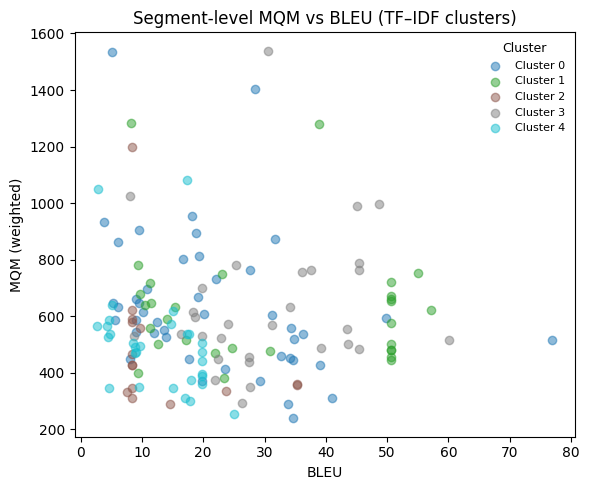

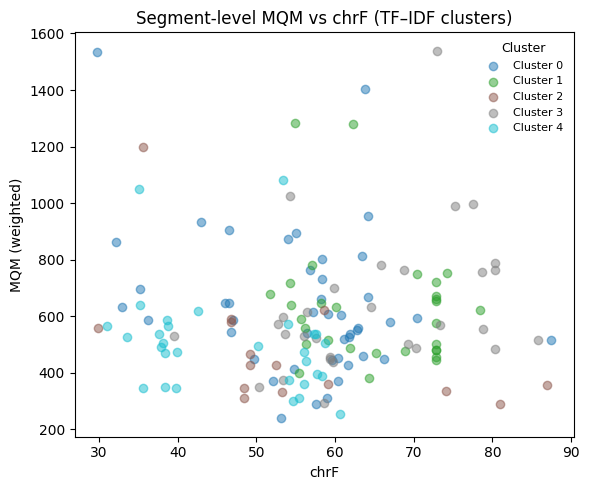

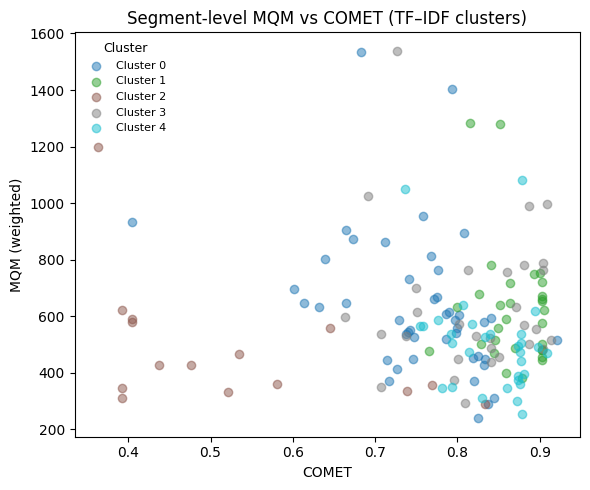

In [65]:
import matplotlib.pyplot as plt

# Get TF–IDF cluster IDs
cluster_ids = sorted(segment_level_metrics_table["cluster_id"].unique())
color_map = plt.cm.get_cmap("tab10", len(cluster_ids))

# One plot per automatic metric, all TF–IDF clusters overlaid
for metric_name in ["BLEU", "chrF", "COMET"]:
    plt.figure(figsize=(6, 5))

    for idx, cluster_id in enumerate(cluster_ids):
        cluster_data = segment_level_metrics_table[
            segment_level_metrics_table["cluster_id"] == cluster_id
        ]

        plt.scatter(
            cluster_data[metric_name],
            cluster_data["mqm_score"],
            alpha=0.5,
            color=color_map(idx),
            label=f"Cluster {cluster_id}",
        )

    plt.xlabel(metric_name)
    plt.ylabel("MQM (weighted)")
    plt.title(f"Segment-level MQM vs {metric_name} (TF–IDF clusters)")
    plt.legend(
        title="Cluster",
        fontsize=8,
        title_fontsize=9,
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

We can also try with embeddings-based clustering.

In [70]:
from sentence_transformers import SentenceTransformer

# Load a lightweight sentence embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode source sentences into dense vectors
source_sentences = segment_level_metrics_table["source"].astype(str).tolist()
sentence_embeddings = embedding_model.encode(
    source_sentences,
    batch_size=32,
    show_progress_bar=True,
)

# Cluster sentences in embedding space
num_clusters = 5
kmeans_model = KMeans(
    n_clusters=num_clusters,
    n_init=10,
    random_state=0,
)
embedding_cluster_ids = kmeans_model.fit_predict(sentence_embeddings)

# Append embedding-based cluster IDs to the segment-level table
segment_level_metrics_table["embedding_cluster"] = embedding_cluster_ids

embedding_cluster_correlation_results = []

for cluster_id in sorted(segment_level_metrics_table["embedding_cluster"].unique()):
    cluster_data = segment_level_metrics_table[
        segment_level_metrics_table["embedding_cluster"] == cluster_id
    ]

    for metric_name in ["BLEU", "chrF", "COMET"]:
        pearson_r, _ = pearsonr(
            cluster_data["mqm_score"],
            cluster_data[metric_name],
        )
        spearman_r, _ = spearmanr(
            cluster_data["mqm_score"],
            cluster_data[metric_name],
        )

        embedding_cluster_correlation_results.append({
            "embedding_cluster": cluster_id,
            "metric": metric_name,
            "num_segments": len(cluster_data),
            "pearson_r": pearson_r,
            "spearman_r": spearman_r,
        })

# Convert to DataFrame
embedding_cluster_correlation_table = pd.DataFrame(embedding_cluster_correlation_results)

embedding_cluster_correlation_table

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

,embedding_cluster,metric,num_segments,pearson_r,spearman_r
0,0,BLEU,30,-0.350920,-0.477662
1,0,chrF,30,-0.264445,-0.367824
2,0,COMET,30,-0.292790,-0.235648
3,1,BLEU,30,-0.132901,-0.090565
4,1,chrF,30,-0.315341,-0.346646
5,1,COMET,30,-0.260122,-0.369785
6,2,BLEU,15,-0.016728,-0.025000
7,2,chrF,15,0.123890,0.425000
8,2,COMET,15,-0.571589,-0.496429
9,3,BLEU,30,-0.105968,-0.140210


/tmp/ipython-input-1973396413.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(cluster_ids))


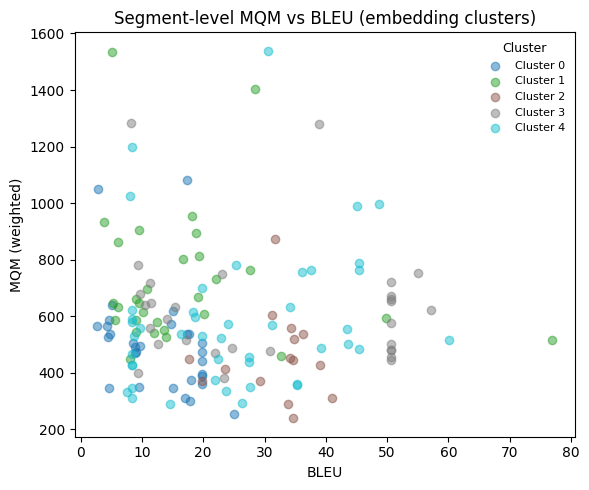

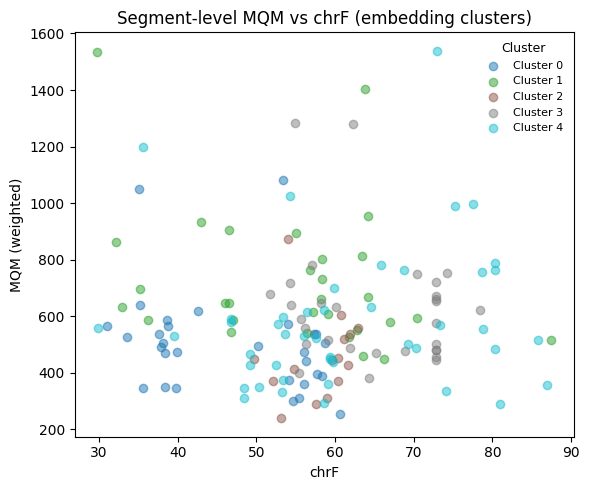

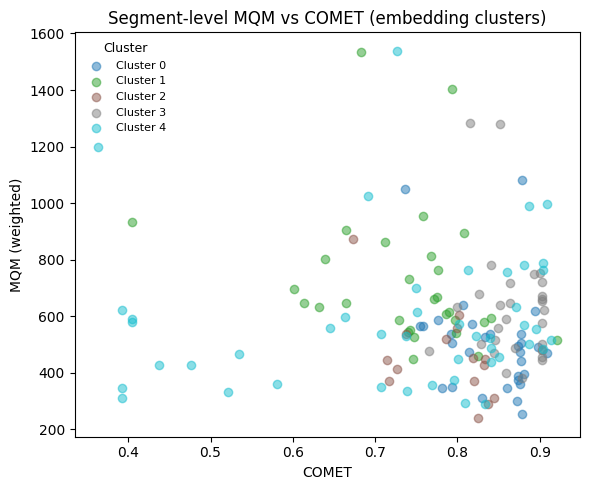

In [63]:
import matplotlib.pyplot as plt

# Get embedding cluster IDs
cluster_ids = sorted(segment_level_metrics_table["embedding_cluster"].unique())
color_map = plt.cm.get_cmap("tab10", len(cluster_ids))

# One plot per automatic metric, all clusters overlaid
for metric_name in ["BLEU", "chrF", "COMET"]:
    plt.figure(figsize=(6, 5))

    for idx, cluster_id in enumerate(cluster_ids):
        cluster_data = segment_level_metrics_table[
            segment_level_metrics_table["embedding_cluster"] == cluster_id
        ]

        plt.scatter(
            cluster_data[metric_name],
            cluster_data["mqm_score"],
            alpha=0.5,
            color=color_map(idx),
            label=f"Cluster {cluster_id}",
        )

    plt.xlabel(metric_name)
    plt.ylabel("MQM (weighted)")
    plt.title(f"Segment-level MQM vs {metric_name} (embedding clusters)")
    plt.legend(
        title="Cluster",
        fontsize=8,
        title_fontsize=9,
        frameon=False,
    )

    plt.tight_layout()
    plt.show()